In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive, files
from PIL import Image
import os
import glob
import io

In [ ]:
# Mount Google Drive (only once)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths to saved models and data
XCEPTION_MODEL_PATH = '/content/drive/MyDrive/MODELS/4000-Modelaa/xception_deepfake_final4000.h5'
FDA_MODEL_PATH = '/content/drive/MyDrive/MODELS/4000-Modelaa/deepfake_classifier.h5'
FUSION_MODEL_PATH = '/content/drive/MyDrive/MODELS/4000-Modelaa/FF_combined.h5'
REAL_IMAGE_DIR = '/content/drive/MyDrive/MORE DATASETS/real'
FAKE_IMAGE_DIR = '/content/drive/MyDrive/MORE DATASETS/fake'

In [ ]:
# --- Load Models ---
def load_xception_model(path):
    try:
        model = load_model(path)
        feature_layer = model.layers[-2].output
        return Model(inputs=model.input, outputs=feature_layer)
    except Exception as e:
        print(f"Error loading Xception model: {e}")
        return None

def load_fda_model(path):
    try:
        model = load_model(path)
        if isinstance(model, tf.keras.Sequential):
            model = tf.keras.Sequential(model.layers[:-1])
            model.build(input_shape=(None, 299, 299, 1))
            return model
        else:
            feature_layer = model.layers[-2].output
            return Model(inputs=model.input, outputs=feature_layer)
    except Exception as e:
        print(f"Error loading FDA model: {e}")
        return None


def load_fusion_model(path):
    try:
        return load_model(path)
    except Exception as e:
        print(f"Error loading fusion model: {e}")
        return None


In [ ]:
def preprocess_xception_image(img_path, target_size=(299, 299)):
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.xception.preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error preprocessing Xception image: {e}")
        return None

def extract_single_feature(model, img_array):
    try:
        feature = model.predict(img_array, verbose=0)
        return feature.flatten()
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

SyntaxError: unmatched '}' (<ipython-input-20-73eb1df15bef>, line 1)

In [ ]:

def preprocess_fda_image(img_path, target_size=(112, 112)):
    try:
        img = load_img(img_path, color_mode='grayscale', target_size=target_size)
        img_array = img_to_array(img)  # Shape: (112, 112, 1)
        if len(img_array.shape) == 2:  # Ensure channel dimension
            img_array = np.expand_dims(img_array, axis=-1)  # Add channel: (112, 112) -> (112, 112, 1)
        img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 112, 112, 1)
        img_array = img_array / 255.0  # Normalize
        img_array = img_array.reshape(img_array.shape[0], -1)  # Flatten to (1, 12544)
        return img_array
    except Exception as e:
        print(f"Error preprocessing FDA image: {e}")
        return None

In [ ]:
def extract_features(model, image_paths, target_size=(299, 299), preprocess_func=None, is_grayscale=False):
    features = []
    target_size = (112, 112) if is_grayscale else target_size  # Use 112x112 for FDA
    for img_path in image_paths:
        try:
            img = load_img(img_path, color_mode='grayscale' if is_grayscale else 'rgb', target_size=target_size)
            img_array = img_to_array(img)  # Shape: (112, 112, 1) for grayscale
            if is_grayscale and len(img_array.shape) == 2:  # Ensure channel dimension
                img_array = np.expand_dims(img_array, axis=-1)  # Add channel: (112, 112) -> (112, 112, 1)
            img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 112, 112, 1)
            if preprocess_func:
                img_array = preprocess_func(img_array)
            elif is_grayscale:
                img_array = img_array / 255.0  # Normalize
                img_array = img_array.reshape(img_array.shape[0], -1)  # Flatten to (1, 12544)
            feature = model.predict(img_array, verbose=0)
            features.append(feature.flatten())
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
    return np.array(features)

In [ ]:
# --- Build Fusion Model ---
def build_fusion_model(x_feat_dim, f_feat_dim):
    x_input = Input(shape=(x_feat_dim,), name='xception_input')
    f_input = Input(shape=(f_feat_dim,), name='fda_input')
    fusion = Concatenate()([x_input, f_input])
    x = Dense(512, activation='relu')(fusion)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[x_input, f_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# --- Train Fusion Model ---
def train_fusion_model():
    # Load image paths and labels
    real_paths = glob.glob(os.path.join(REAL_IMAGE_DIR, '*.jpg')) + glob.glob(os.path.join(REAL_IMAGE_DIR, '*.png'))
    fake_paths = glob.glob(os.path.join(FAKE_IMAGE_DIR, '*.jpg')) + glob.glob(os.path.join(FAKE_IMAGE_DIR, '*.png'))
    all_paths = real_paths + fake_paths
    all_labels = np.array([1]*len(real_paths) + [0]*len(fake_paths))  # 1=real, 0=fake

    print(f"Found {len(real_paths)} real and {len(fake_paths)} fake images.")

    # Load pre-trained feature extractors
    x_model = load_xception_model(XCEPTION_MODEL_PATH)
    f_model = load_fda_model(FDA_MODEL_PATH)

    if x_model is None or f_model is None:
        print("Failed to load feature extractors. Aborting training.")
        return False

    # Extract features
    print("Extracting Xception features...")
    x_features = extract_features(x_model, all_paths, preprocess_func=tf.keras.applications.xception.preprocess_input)
    print("Extracting FDA features...")
    f_features = extract_features(f_model, all_paths, is_grayscale=True)

    if x_features.shape[0] == 0 or f_features.shape[0] == 0:
        print("No features extracted. Check image paths or preprocessing.")
        return False

    # Build and train fusion model
    print("Building and training fusion model...")
    fusion_model = build_fusion_model(x_features.shape[1], f_features.shape[1])
    fusion_model.fit(
        [x_features, f_features], all_labels,
        epochs=25,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Save fusion model
    fusion_model.save(FUSION_MODEL_PATH)
    print(f"Fusion model saved at: {FUSION_MODEL_PATH}")
    return True

In [ ]:
def predict_image(img_path, x_model, f_model, fusion_model):
    try:
        # Preprocess for both models
        x_img_array = preprocess_xception_image(img_path)
        f_img_array = preprocess_fda_image(img_path)

        if x_img_array is None or f_img_array is None:
            return None

        # Extract features
        x_features = extract_single_feature(x_model, x_img_array)
        f_features = extract_single_feature(f_model, f_img_array)

        if x_features is None or f_features is None:
            return None

        # Predict using fusion model
        prediction = fusion_model.predict(
            [np.expand_dims(x_features, axis=0), np.expand_dims(f_features, axis=0)],
            verbose=0
        )
        return prediction[0][0]
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None


In [ ]:
# --- Main Execution ---
def main():
    # Train the fusion model
    print("Starting fusion model training...")
    success = train_fusion_model()

    if success:
        print("Training completed successfully.")
    else:
        print("Training failed. Please check model paths, image directories, or preprocessing.")

# Run the main function
if __name__ == "__main__":
    main()

Starting fusion model training...
Found 2000 real and 2000 fake images.


FDA Model Summary:


Model: "DeepfakeClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,423,555 (24.50 MB)

 Trainable params: 6,423,553 (24.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Extracting Xception features...
Extracting FDA features...
Building and training fusion model...
Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6991 - loss: 1.1534 - val_accuracy: 0.8250 - val_loss: 0.4042
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8592 - loss: 0.3332 - val_accuracy: 0.7600 - val_loss: 0.5358
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8792 - loss: 0.2880 - val_accuracy: 0.6162 - val_loss: 0.8729
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8908 - loss: 0.2643 - val_accuracy: 0.9588 - val_loss: 0.1187
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8961 - loss: 0.2420 - val_accuracy: 0.9450 - val_loss: 0.1487
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8862 - loss: 0.2716 - val_accuracy: 0.8750 - val_loss: 0.3070
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9105 - loss: 0.2346 - val_accuracy: 0.8300 - val_loss: 0.4125
Epoch 8

Fusion model saved at: /content/drive/MyDrive/MODELS/4000-Modelaa/FF_combined.h5
Training completed successfully.


In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import os

In [ ]:
# --- Test with Uploaded Image ---
def test_with_upload():
    # Load models
    print("Loading models for testing...")
    x_model = load_xception_model(XCEPTION_MODEL_PATH)
    f_model = load_fda_model(FDA_MODEL_PATH)
    fusion_model = load_fusion_model(FUSION_MODEL_PATH)

    if x_model is None or f_model is None or fusion_model is None:
        print("Failed to load one or more models. Please check paths and model files.")
        return

    # Upload image
    print("Please upload an image (jpg or png):")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    # Process the uploaded image
    try:
        img_name = list(uploaded.keys())[0]
        img_path = f"/content/{img_name}"

        # Save uploaded image
        with open(img_path, 'wb') as f:
            f.write(uploaded[img_name])

         # Display the uploaded image
        img = Image.open(img_path)
        plt.figure(figsize=(6, 6))  # You can increase size here
        plt.imshow(img)
        plt.axis('off')
        plt.title("Uploaded Image")
        plt.show()

        # Make prediction
        prediction = predict_image(img_path, x_model, f_model, fusion_model)

        if prediction is not None:
            label = "Real" if prediction >= 0.5 else "Fake"
            confidence = prediction if prediction >= 0.5 else 1 - prediction
            print(f"\nPrediction: {label}")
            print(f"Confidence: {confidence:.4f}")
        else:
            print("Prediction failed.")

        # Clean up
        if os.path.exists(img_path):
            os.remove(img_path)
            print("Uploaded image file removed.")

    except Exception as e:
        print(f"Error processing image: {e}")
        if os.path.exists(img_path):
            os.remove(img_path)

Starting testing phase...
Loading models for testing...


Please upload an image (jpg or png):


Saving download.jpg to download.jpg


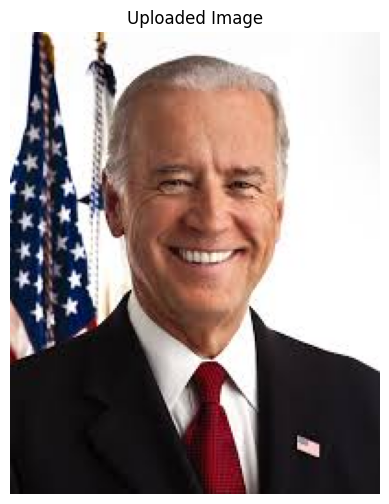


Prediction: Real
Confidence: 0.6310
Uploaded image file removed.
Loading models for testing...


Please upload an image (jpg or png):


Saving df01617.jpg to df01617.jpg


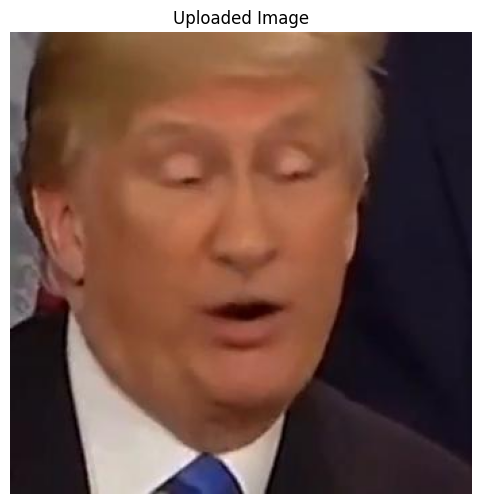


Prediction: Fake
Confidence: 0.7904
Uploaded image file removed.
Loading models for testing...


Please upload an image (jpg or png):


Saving 1746703810679.jpg to 1746703810679.jpg


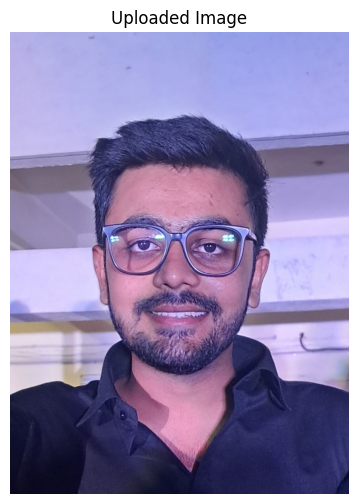


Prediction: Real
Confidence: 1.0000
Uploaded image file removed.


In [ ]:
# --- Main Execution ---
def main():
    # Test with uploaded images
    print("Starting testing phase...")
    while True:
        test_with_upload()
        # Ask if user wants to test another image
        try:
            user_input = input("\nDo you want to  test another image? (yes/no):\n  ").strip().lower()
            if user_input != 'y':
                print("Exiting testing phase.")
                break
        except KeyboardInterrupt:
            print("\nTesting interrupted. Exiting testing phase.")
            break

# Run the main function
if __name__ == "__main__":

    main()